### Consumo de combustible: Análisis Exploratorio

In [1]:
import pandas as pd

consumo_2024 = pd.read_excel(
    './Datos_consumos/CONSUMO-HIDROCARBUROS-2024-12.xlsx',
    sheet_name='CONSUMO',
    header=6,
    parse_dates=['Fecha']
)

consumo_2025 = pd.read_excel(
    './Datos_consumos/VENTAS-HIDROCARBUROS-2025-05.xlsx',
    sheet_name='VENTAS_IMP',
    header=6,
    parse_dates=['Fecha']
)

consumo = pd.concat([consumo_2024, consumo_2025], ignore_index=True)
consumo.sort_values('Fecha', inplace=True)

consumo.set_index('Fecha', inplace=True)

diesel_cols = [c for c in consumo.columns if 'Diesel' in c]
consumo['Diesel'] = consumo[diesel_cols].sum(axis=1)

df_consumo = consumo.rename(columns={
    'Gasolina regular': 'Gasolina Regular',
    'Gasolina superior': 'Gasolina Super',
    'Gas licuado de petróleo': 'Gas Licuado'
})[['Gasolina Regular', 'Gasolina Super', 'Diesel', 'Gas Licuado']]

df_consumo.head()


,Gasolina Regular,Gasolina Super,Diesel,Gas Licuado
Fecha,,,,
2000-01-01 00:00:00,202645.20,308156.82,634667.06,194410.476190
2000-02-01 00:00:00,205530.96,307766.31,642380.66,174710.552381
2000-03-01 00:00:00,229499.56,331910.29,699807.25,189234.066667
2000-04-01 00:00:00,210680.40,315648.08,586803.98,174330.607143
2000-05-01 00:00:00,208164.34,319667.97,656948.20,191745.147619


In [2]:
import pandas as pd

df_consumo.index = pd.to_datetime(df_consumo.index, errors='coerce')

df_consumo = df_consumo[df_consumo.index.notna()]

df_consumo = df_consumo[~df_consumo.index.duplicated(keep='first')]

df_consumo = df_consumo[df_consumo.index <= '2025-05-01']

print(df_consumo.shape)  
print("Desde", df_consumo.index.min(), "hasta", df_consumo.index.max())


(305, 4)
Desde 2000-01-01 00:00:00 hasta 2025-05-01 00:00:00


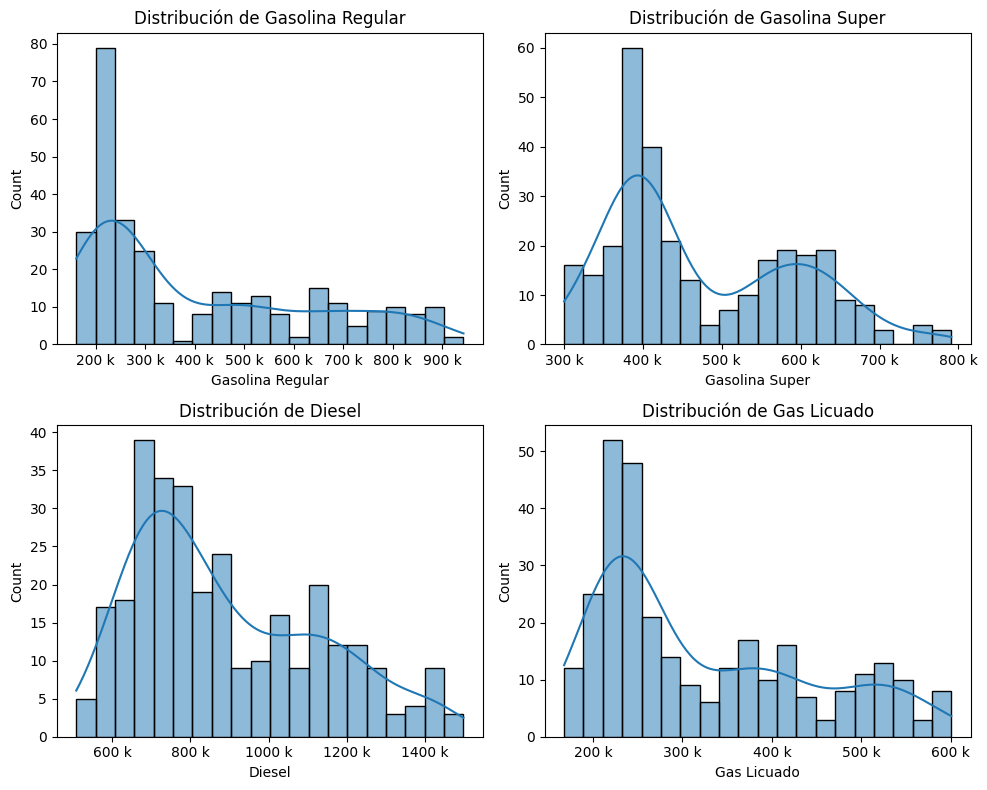

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as mtick

k_formatter = mtick.FuncFormatter(lambda x, pos: f'{int(x/1000)} k')

fig, axes = plt.subplots(2, 2, figsize=(10, 8))
for ax, col in zip(axes.flatten(), df_consumo.columns):
    sns.histplot(df_consumo[col], bins=20, kde=True, ax=ax)
    ax.set_title(f'Distribución de {col}')
    ax.xaxis.set_major_formatter(k_formatter)
plt.tight_layout()
plt.show()


Se puede observar como los cuatro tipos de combustible poseen una cola hacia la derecha, siendo más notaria en la Gasolina Regular lo cual indica que la mayoría de los meses concentra su consumo en valores bajos‐medios, pero que existen unos pocos meses con consumos excepcionalmente altos que extienden la cola hacia la derecha. Por otro lado vemos con la Super tiene sus picos en valores más altos y pareciera tener un segundo pico más amortiguado. El caso de Diesel es interesante porque parecer ser la que más amortiguación posee teniendo una cola no tan marcada, lo cual indica una distribución más amplia que las otras. Por último tenemos el gas licuado, el cual parece ser aún más estable.

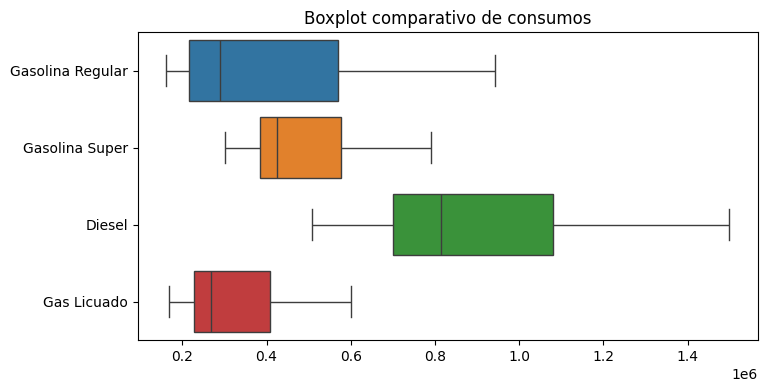

In [7]:
plt.figure(figsize=(8, 4))
sns.boxplot(data=df_consumo, orient='h')
plt.title('Boxplot comparativo de consumos')
plt.show()





Se puede observar como Diesel es el combustible que más consume, pero también es el mayor variabilidad. El caso contrario es el gas licuado, el cual es el menos consumido y también el que posee menor dispersión. En medio tenemos la gasolina Super y Regular, siendo Super ligeramente más estable que Regular, pero sin superar al Gas licuado.

Matriz de correlación:
                   Gasolina Regular  Gasolina Super    Diesel  Gas Licuado
Gasolina Regular          1.000000        0.936525  0.930957     0.982216
Gasolina Super            0.936525        1.000000  0.926488     0.925740
Diesel                    0.930957        0.926488  1.000000     0.916637
Gas Licuado               0.982216        0.925740  0.916637     1.000000 



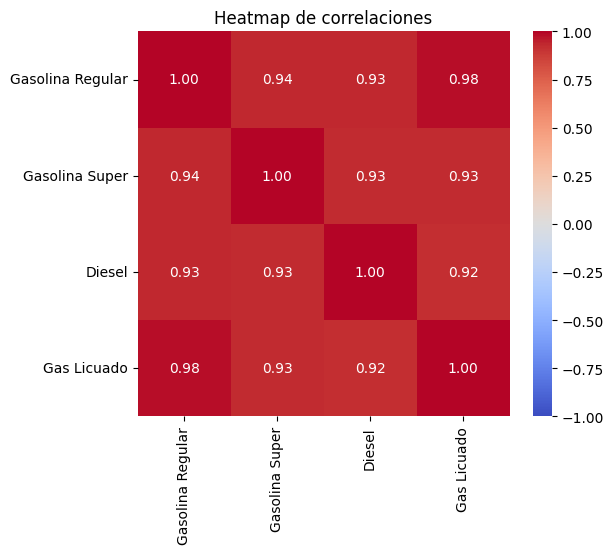

In [5]:
corr = df_consumo.corr()
print("Matriz de correlación:\n", corr, "\n")

plt.figure(figsize=(6, 5))
sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Heatmap de correlaciones')
plt.show()


Se observa como los 4 tipos de combustible seleccionados poseen una correlación > .90 lo cual es bastante interesante, pero dentro de todas las correlaciones la qeu posee el valor más alto es la de gas licuado - gasolina Regular. Lo cual resulta interesante si contemplamos que el gas licuado es la más estable y Regular era la segunda más variada.

## Análisis de Serie

Inicio: 2000-01-01
Fin:    2025-05-01
Frecuencia: <MonthBegin>



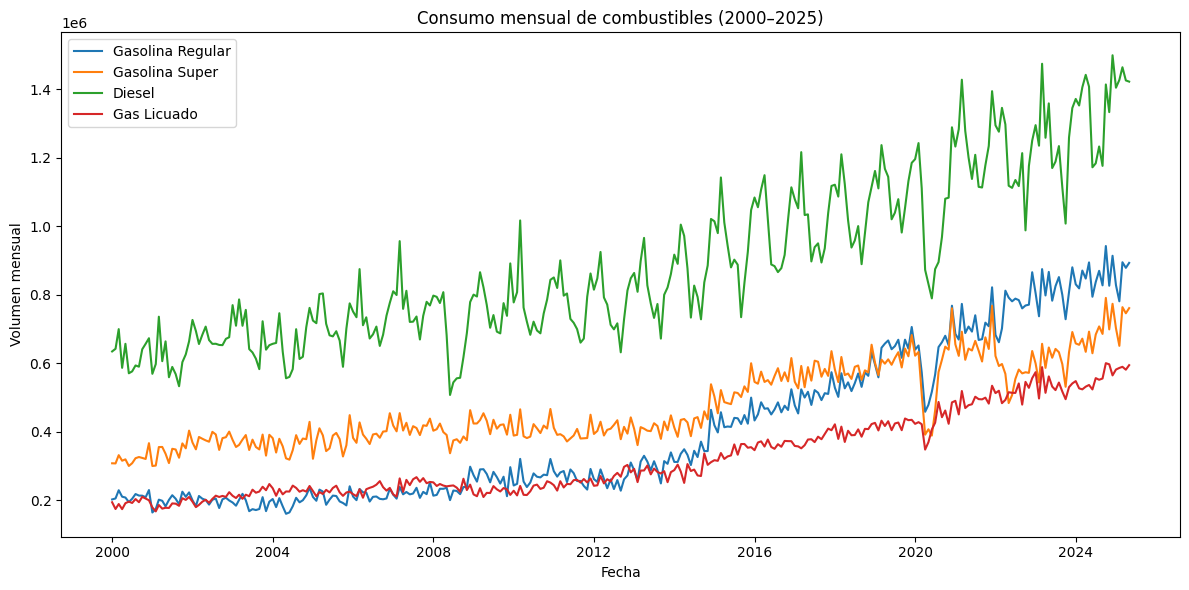

In [10]:
import matplotlib.pyplot as plt

inicio = df_consumo.index.min()
fin    = df_consumo.index.max()

frecuencia = 'MS'

df_consumo.index = pd.DatetimeIndex(df_consumo.index.values, freq=frecuencia)

print(f"Inicio: {inicio.date()}")
print(f"Fin:    {fin.date()}")
print(f"Frecuencia: {df_consumo.index.freq}\n")

plt.figure(figsize=(12, 6))
for col in df_consumo.columns:
    plt.plot(df_consumo.index, df_consumo[col], label=col)
plt.title('Consumo mensual de combustibles (2000–2025)')
plt.xlabel('Fecha')
plt.ylabel('Volumen mensual')
plt.legend()
plt.tight_layout()
plt.show()


Se observa como inicia el primero de enero del año 2000 y finaliza el primero de mayo del 2025, lo cual se alinea con lo esperado.  
Con respecto de la series se encuentra una ligera tendencia de crecimiento sobre las cuatro, siendo la más marcada de Diesel, esto podría indicarnos que a medida que avanzan los años han empezado a circular más carros que funcionan con Diesel, aunque también es cierto que desde un principio de la serie este ha sido el valor con más alto volumen. A primera vista puede ver un ligero patrón en donde los picos son muy similares y los valles son constantes, esto es algo que valdría la pena explorar a detalle. 
Super y Regular tienen un comportamiento similar, siendo Super ligeramente superior en los primeros años, pero teniendo una pequeña caída en los más recientes los cuales hacen que Regular tome la delantera. Además, se observa como en los años recientes llegaron a traslparse lo que nos muestra que los comportamientos son muy similares. 
Por último, el gas licuado es que menos tendencia marca, pero aún así se obsera como ha crecido, especilamente a partir del 2015, es ahí en donde el crecimiento se marca más.  
A simple vista se observan ciclos anuales: picos recurrentes en ciertos meses (posiblemente verano o fines de año) y valles en temporadas de menor consumo. 
La caída en 2020 puede atribuirse a la pandemia, pero se observa como en el siguiente se recupera.

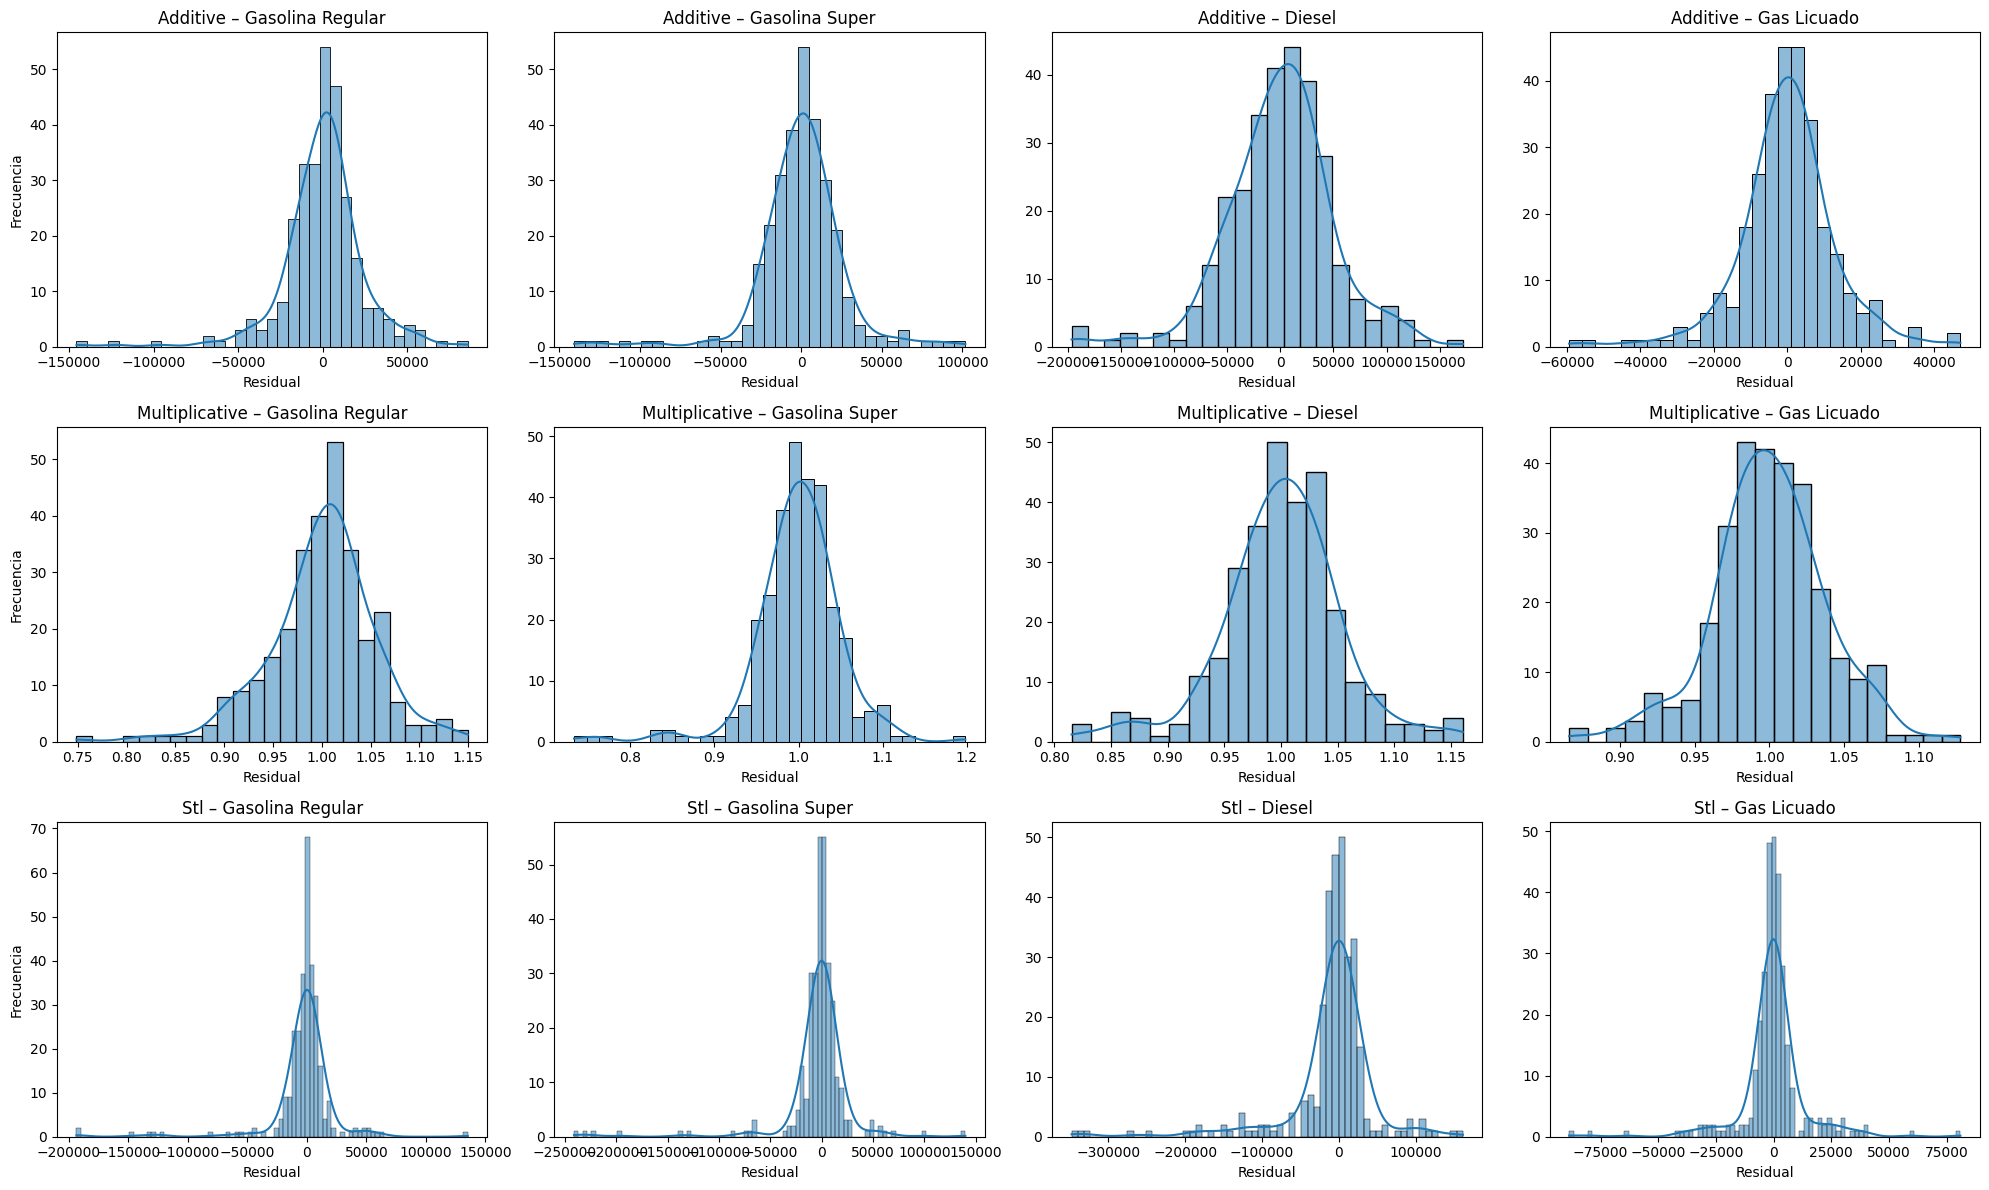

                        Media                                      Std  \
Método                    STL    additive multiplicative           STL   
Combustible                                                              
Diesel           -9984.355800  113.056313       1.000000  59602.853310   
Gas Licuado       -206.779209    3.693020       0.999833  14730.900592   
Gasolina Regular -2414.526305  125.635203       0.999890  27853.451001   
Gasolina Super   -3424.829777   13.508930       0.999715  33832.770090   

                                               
Método                additive multiplicative  
Combustible                                    
Diesel            50537.301590       0.053670  
Gas Licuado       13037.948825       0.038272  
Gasolina Regular  24169.838406       0.054516  
Gasolina Super    26820.454099       0.051546  


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose, STL

periodo = 12
metodos = ['additive', 'multiplicative', 'STL']
residuos_summary = []

fig, axes = plt.subplots(len(metodos), len(df_consumo.columns), figsize=(20, 12))

for i, metodo in enumerate(metodos):
    for j, col in enumerate(df_consumo.columns):
        # Descomposición según el método
        if metodo in ['additive', 'multiplicative']:
            res = seasonal_decompose(df_consumo[col], model=metodo, period=periodo)
            resid = res.resid.dropna()
        else:
            stl = STL(df_consumo[col], period=periodo, robust=True)
            fit = stl.fit()
            resid = fit.resid.dropna()
        # Guardar estadísticas
        residuos_summary.append({
            'Método': metodo,
            'Combustible': col,
            'Media': resid.mean(),
            'Std': resid.std()
        })
        ax = axes[i, j]
        sns.histplot(resid, kde=True, ax=ax)
        ax.set_title(f"{metodo.capitalize()} – {col}")
        ax.set_xlabel('Residual')
        ax.set_ylabel('Frecuencia' if j == 0 else '')

fig.tight_layout()
plt.show()

res_df = pd.DataFrame(residuos_summary)
resumen = res_df.pivot(index='Combustible', columns='Método', values=['Media', 'Std'])
print(resumen)


Se realizó una tabla para comparar cuál de los tres modelos sería el ideal para la descomposición. Lo que se busca es método que tenga media lo más cercana posible al valor teórico (0 o 1), y tenga la desviación estándar más baja de todos. En este caso el que más se adecua es el modelo aditivo.

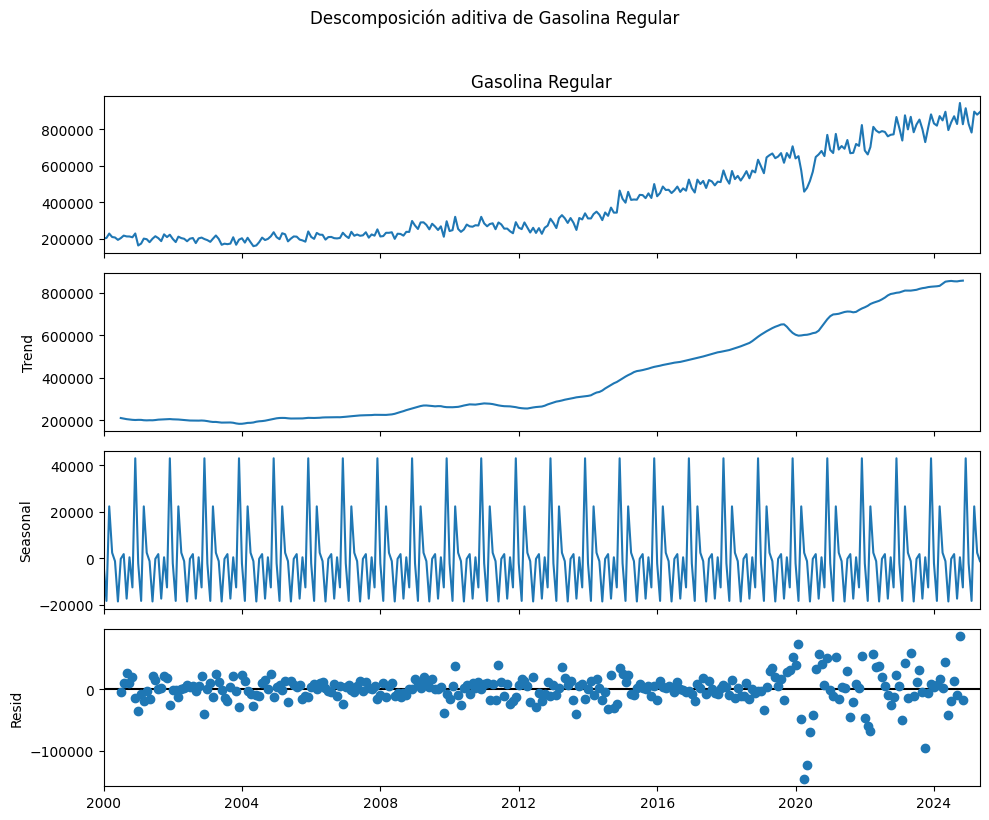

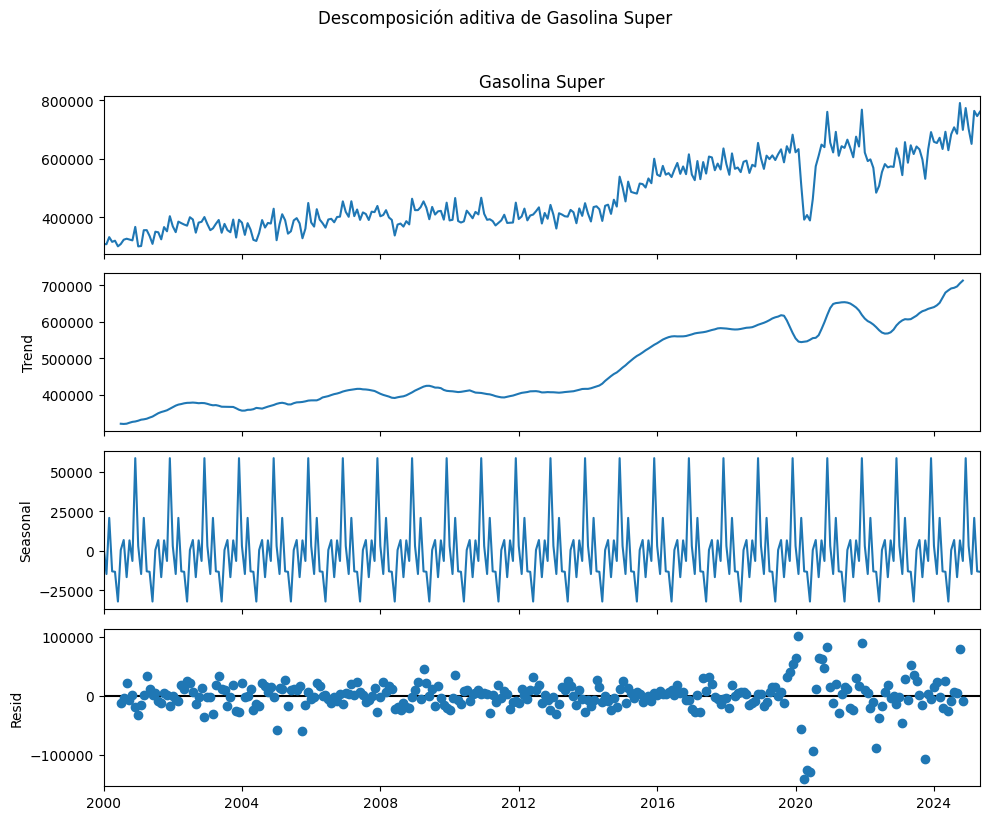

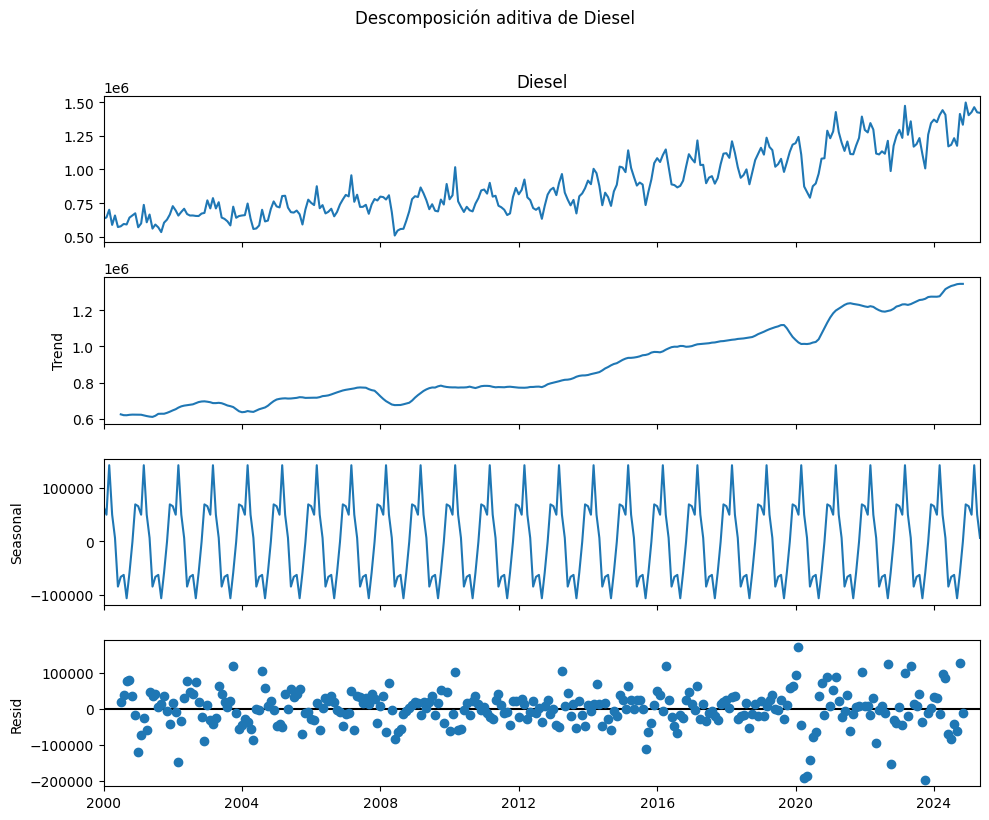

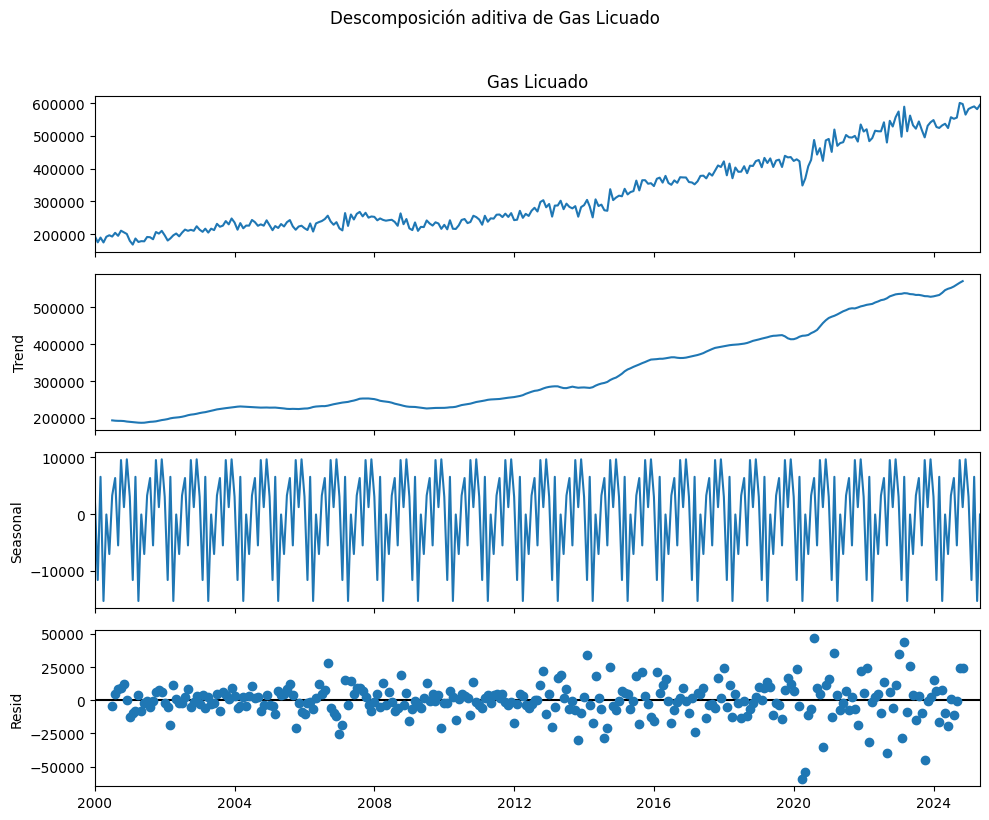

In [16]:
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

periodo = 12

for col in df_consumo.columns:
    result_add = seasonal_decompose(
        df_consumo[col],
        model='additive',
        period=periodo
    )
    fig = result_add.plot()
    fig.set_size_inches(10, 8)
    fig.suptitle(f'Descomposición aditiva de {col}', y=1.02)
    plt.tight_layout()
    plt.show()



Se observa como al descomponer la serie de la gasolina Regular se presenta tendencia plana al inicio, 2000 - 2010, que se acelera a partir del 2011 y 2019 y refleja el valle de la pandemia. Acerca de la estacionalidad, muestra un ciclo anual muy consistente, con picos y valles de ±20 000–25 000 unidades que se repiten cada año. Los residuos están centrados en cero y con varianza estable salvo por algunos outliers (especialmente en 2020–2022) lo que significa que el modelo captura correctamente la estructura sistemática de la serie.  
La serie descompuesta de la gasolina Super muestra una muy ligera tendencia creciente al inicio, del 2000 - 2014 esta se mantiene constante, a partir del 2015 su crecimiento aumenta, pasando también por el valle del 2020. En estacionalidad el ciclo anual es muy parecido al de la Regular comprobando que estos combustibles tienen un compartamiento muy similar. Sus residuos están centrados en cero, pero también es afectada por los outliners que afectan a la Regular.  
Diesel refleja una tendencia ligeramente pronunciada y con dos valles hasta 2013, a apartir de ese año su crecimiento es más acelerado, pero sin omitir el valle del 2020. Su comportamiento estacional consta de picos que oscilan entre las -100,000 - 100,000 unidades que se repiten cada años. Sus residuos están más disperos que los de la gasolina Super y Regular. Especialmente en los períodos del 2000-2008 y en 2020-2024 se disparan los outliners. 
El gas licuado muestra una tendencia claramente pronunciada desde 2001-2025, incluso el valle del 2020 no se tan marcado como en los otros combustibles, lo que nos demuestra que tuvo más estabilidad que los otros incluso en pandemia, un aspecto interesante a notar. La estacionalidad marca un comportamiento repetitivo a partir del 2001 con valores que oscilan entre -10,000-10,000. Sus residuos se muestran centrados en cero (con ligeros outliners) desde 2000-2012, en 2013 se dispara se empieza a ver más incertidumbre quesolo aumenta hasta llegar al 2025.

Ninguna de las cuatro series es estacionaria ni en media ni en varianza: todas muestran una clara tendencia a largo plazo (media que crece) y una amplitud estacional que tiende a aumentar con el nivel de la serie, lo que viola la constancia de varianza. Los residuos del modelo aditivo, aunque centrados en cero, presentan varianza creciente en los periodos de mayor tendencia y varios outliers (por ejemplo 2020–2022), confirmando heterocedasticidad. Por tanto, para aproximarnos a la estacionariedad convendría primero estabilizar la varianza para eliminar la tendencia y la componente cíclica; solo así podremos trabajar con series estacionarias en media y varianza para modelos ARIMA o de forecasting basados en ruido blanco.


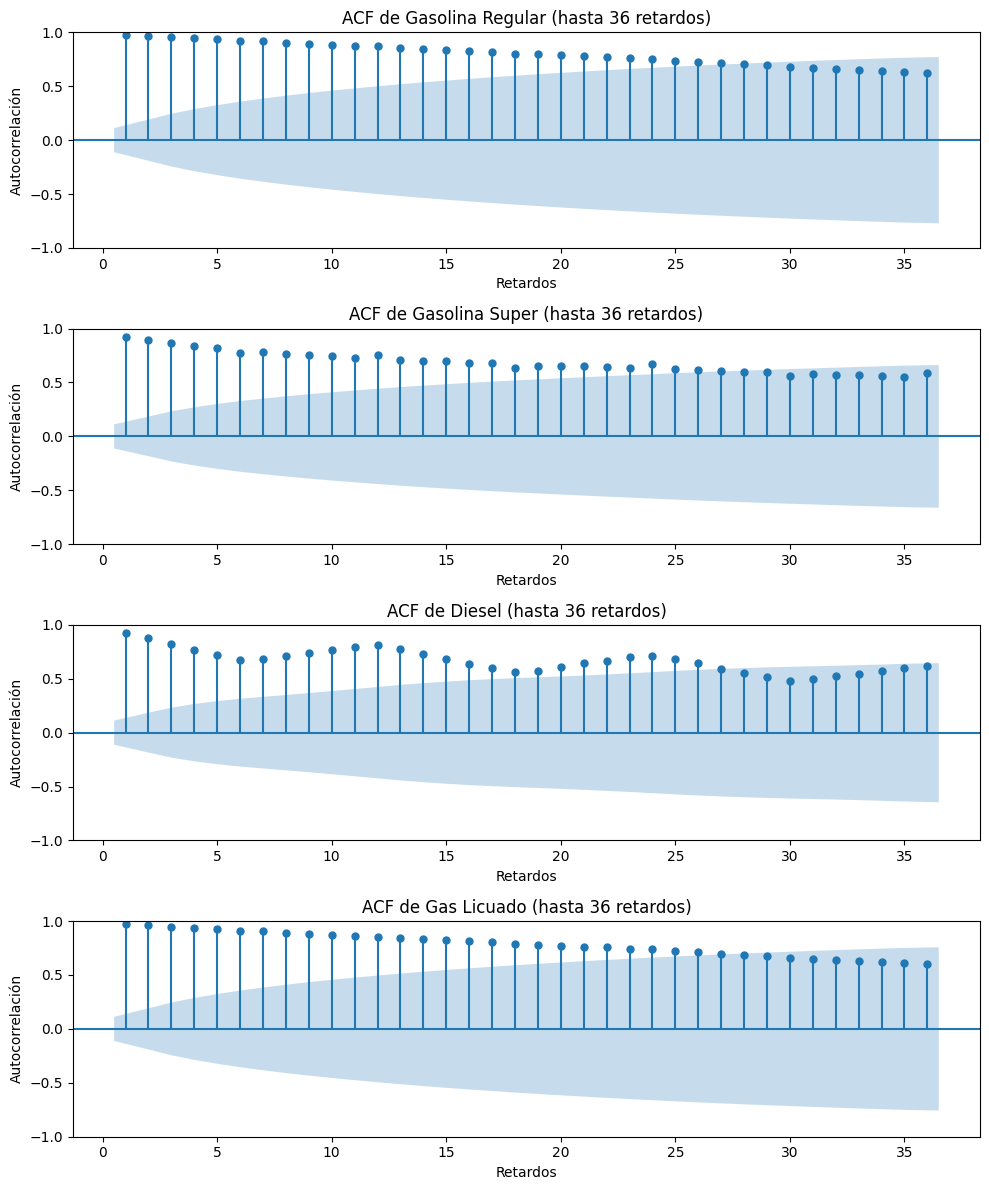

In [17]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf

fig, axes = plt.subplots(len(df_consumo.columns), 1, figsize=(10, 12))

for ax, col in zip(axes, df_consumo.columns):
    plot_acf(df_consumo[col], lags=36, ax=ax, zero=False)
    ax.set_title(f'ACF de {col} (hasta 36 retardos)')
    ax.set_xlabel('Retardos')
    ax.set_ylabel('Autocorrelación')

plt.tight_layout()
plt.show()


El autocorrelgrama muestra un lag bastante alto para los cuatro tipos de combustibles, lo cual demuestra que la serie no es estacionaria: las barras de autocorrelación permanecen por encima de la banda de confianza incluso en retardos de 12, 24 o 36 meses, indicando que el consumo de un mes arrastra con fuerza la influencia de valores muy lejanos (memoria de largo plazo) y que el nivel promedio cambia con el tiempo. 

In [ ]:
from statsmodels.tsa.stattools import adfuller

for col in df_consumo.columns:
    adf_res = adfuller(df_consumo[col].dropna())
    print(f"{col}:")
    print(f"  ADF Statistic: {adf_res[0]:.4f}")
    print(f"  p-value:        {adf_res[1]:.4f}")
    print(f"  Critical Values:")
    for key, val in adf_res[4].items():
        print(f"    {key}: {val:.4f}")
    print("-" * 40)



Gasolina Regular:
  ADF Statistic: 2.2922
  p-value:        0.9990
  Critical Values:
    1%: -3.4531
    5%: -2.8716
    10%: -2.5721
----------------------------------------
Gasolina Super:
  ADF Statistic: -0.0291
  p-value:        0.9561
  Critical Values:
    1%: -3.4529
    5%: -2.8715
    10%: -2.5721
----------------------------------------
Diesel:
  ADF Statistic: 0.5563
  p-value:        0.9865
  Critical Values:
    1%: -3.4529
    5%: -2.8715
    10%: -2.5721
----------------------------------------
Gas Licuado:
  ADF Statistic: 1.5592
  p-value:        0.9977
  Critical Values:
    1%: -3.4525
    5%: -2.8713
    10%: -2.5720
----------------------------------------


La prueba de Dickey–Fuller  demuestra que ninguna de las cuatro series es estacionaria en media, en todos los casos el estadístico ADF queda por encima de los valores críticos (1 %, 5 % y 10 %) y los p-values son muy altos (≈0.95–0.999), por lo que no podemos rechazar la hipótesis nula de raíz unitaria.  
Para lograr estacionariedad en media será necesario diferenciar cada serie y luego volver a aplicar la prueba ADF, buscando esta vez un estadístico menor que el valor crítico y un p-value < 0.05.

In [22]:
# ─── Bloque X: Diferenciación y nueva prueba ADF ───
from statsmodels.tsa.stattools import adfuller

# 1. Diferenciar las series para eliminar la tendencia
df_consumo_diff = df_consumo.diff().dropna()

# 2. Aplicar ADF a cada serie diferenciada
for col in df_consumo_diff.columns:
    adf_res = adfuller(df_consumo_diff[col])
    print(f"{col} (diferenciada):")
    print(f"  ADF Statistic: {adf_res[0]:.4f}")
    print(f"  p-value:       {adf_res[1]:.4f}")
    print("  Critical Values:")
    for key, val in adf_res[4].items():
        print(f"    {key}: {val:.4f}")
    print("-" * 40)


Gasolina Regular (diferenciada):
  ADF Statistic: -4.3503
  p-value:       0.0004
  Critical Values:
    1%: -3.4533
    5%: -2.8717
    10%: -2.5722
----------------------------------------
Gasolina Super (diferenciada):
  ADF Statistic: -4.3502
  p-value:       0.0004
  Critical Values:
    1%: -3.4533
    5%: -2.8717
    10%: -2.5722
----------------------------------------
Diesel (diferenciada):
  ADF Statistic: -7.2644
  p-value:       0.0000
  Critical Values:
    1%: -3.4529
    5%: -2.8715
    10%: -2.5721
----------------------------------------
Gas Licuado (diferenciada):
  ADF Statistic: -9.6341
  p-value:       0.0000
  Critical Values:
    1%: -3.4525
    5%: -2.8713
    10%: -2.5720
----------------------------------------


Se aplicó una diferenciación para ajustar los valores, la cual demostró una alta efectiviadd, ya que ahora los estadísticos ADF son menos que los valores críticos al 1% y lo p-values son casi 0, por lo que se rechaza la hipótesis nula de raiz unitaria en cada serie.

### Selección de parámetros


# DISCLAIMER

Hasta ahorita entendí que bastaba con solo 2. Así que voy a continuar con datos de la Gasolina Super y Diesel.

![GIF explicativo](https://media0.giphy.com/media/v1.Y2lkPTc5MGI3NjExbXo4eHhibDhnbzJscnBjMTliMGkxbzdhdmsxYjh5bGw3YjkwajEzcyZlcD12MV9pbnRlcm5hbF9naWZfYnlfaWQmY3Q9Zw/8boMf1VXVHoJy/giphy.gif)

In [ ]:
import pmdarima as pm

modelos_arima = {}

for col in df_consumo.columns:
    modelo = pm.auto_arima(
        df_consumo[col],
        d=1,
        seasonal=False,
        start_p=0, max_p=5,
        start_q=0, max_q=5,
        information_criterion='aic',
        trace=True,
        error_action='ignore',
        suppress_warnings=True
    )
    print(f"=== {col} ===")
    print(modelo.summary())
    print()
    modelos_arima[col] = modelo


C:\Users\irvin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\irvin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=7321.802, Time=0.34 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=7264.269, Time=0.18 sec


C:\Users\irvin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\irvin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=7241.699, Time=1.14 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=7320.743, Time=0.08 sec


C:\Users\irvin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\irvin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=7243.405, Time=1.94 sec


C:\Users\irvin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=7249.660, Time=1.13 sec


C:\Users\irvin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=7232.706, Time=3.54 sec


C:\Users\irvin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=7234.293, Time=3.91 sec


C:\Users\irvin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=7233.553, Time=3.07 sec


C:\Users\irvin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=7249.668, Time=1.37 sec


C:\Users\irvin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=7242.541, Time=2.07 sec


C:\Users\irvin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=14.93 sec


C:\Users\irvin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,2)(0,0,0)[0]             : AIC=7238.624, Time=3.61 sec

Best model:  ARIMA(1,1,2)(0,0,0)[0] intercept
Total fit time: 37.427 seconds
=== Gasolina Regular ===
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  305
Model:               SARIMAX(1, 1, 2)   Log Likelihood               -3611.353
Date:                Sat, 19 Jul 2025   AIC                           7232.706
Time:                        14:46:06   BIC                           7251.292
Sample:                    01-01-2000   HQIC                          7240.141
                         - 05-01-2025                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   5788.1771   1419.925      4.0

C:\Users\irvin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\irvin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\irvin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=7362.846, Time=0.16 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=7316.655, Time=0.23 sec


C:\Users\irvin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=7308.007, Time=0.75 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=7361.201, Time=0.08 sec


C:\Users\irvin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\irvin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=7309.919, Time=1.24 sec


C:\Users\irvin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=7310.144, Time=1.55 sec


C:\Users\irvin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=7307.776, Time=4.60 sec


C:\Users\irvin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=7313.981, Time=4.51 sec


C:\Users\irvin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=7308.388, Time=3.22 sec


C:\Users\irvin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=7310.885, Time=1.77 sec


C:\Users\irvin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=7311.194, Time=5.63 sec


C:\Users\irvin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=7309.691, Time=2.76 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=7312.782, Time=0.20 sec

Best model:  ARIMA(1,1,2)(0,0,0)[0] intercept
Total fit time: 26.746 seconds
=== Gasolina Super ===
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  305
Model:               SARIMAX(1, 1, 2)   Log Likelihood               -3648.888
Date:                Sat, 19 Jul 2025   AIC                           7307.776
Time:                        14:46:33   BIC                           7326.362
Sample:                    01-01-2000   HQIC                          7315.211
                         - 05-01-2025                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------

C:\Users\irvin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\irvin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\irvin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=7767.577, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=7758.320, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=7758.942, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=7765.861, Time=0.01 sec


C:\Users\irvin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\irvin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\irvin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\irvin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Pyt

 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=7760.191, Time=0.14 sec


C:\Users\irvin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=7760.157, Time=0.21 sec


C:\Users\irvin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=7752.127, Time=0.36 sec


C:\Users\irvin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=7741.167, Time=0.43 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=7762.015, Time=0.18 sec


C:\Users\irvin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\irvin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=7729.333, Time=0.57 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=7763.887, Time=0.17 sec


C:\Users\irvin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\irvin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=7710.326, Time=0.85 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=7763.586, Time=0.19 sec


C:\Users\irvin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\irvin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(5,1,2)(0,0,0)[0] intercept   : AIC=7663.927, Time=2.10 sec


C:\Users\irvin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=7741.087, Time=1.14 sec


C:\Users\irvin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(5,1,3)(0,0,0)[0] intercept   : AIC=7672.283, Time=2.58 sec


C:\Users\irvin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=7.75 sec


C:\Users\irvin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(5,1,2)(0,0,0)[0]             : AIC=7656.626, Time=12.80 sec


C:\Users\irvin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,1,2)(0,0,0)[0]             : AIC=7667.066, Time=5.76 sec


C:\Users\irvin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(5,1,1)(0,0,0)[0]             : AIC=7713.227, Time=0.60 sec


C:\Users\irvin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(5,1,3)(0,0,0)[0]             : AIC=7667.556, Time=1.77 sec


C:\Users\irvin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,1,1)(0,0,0)[0]             : AIC=7728.372, Time=0.69 sec


C:\Users\irvin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,1,3)(0,0,0)[0]             : AIC=inf, Time=2.11 sec

Best model:  ARIMA(5,1,2)(0,0,0)[0]          
Total fit time: 40.623 seconds
=== Diesel ===
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  305
Model:               SARIMAX(5, 1, 2)   Log Likelihood               -3820.313
Date:                Sat, 19 Jul 2025   AIC                           7656.626
Time:                        14:47:13   BIC                           7686.362
Sample:                    01-01-2000   HQIC                          7668.521
                         - 05-01-2025                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.1660      0.060     19.309      0.000  

C:\Users\irvin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\irvin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\irvin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\irvin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Pyt

 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=6841.387, Time=0.16 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=6842.446, Time=0.13 sec


C:\Users\irvin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\irvin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=6841.014, Time=0.24 sec


C:\Users\irvin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=6839.139, Time=0.25 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=6841.774, Time=0.19 sec


C:\Users\irvin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\irvin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=6845.685, Time=0.18 sec


C:\Users\irvin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=6841.947, Time=0.57 sec


C:\Users\irvin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,1)(0,0,0)[0]             : AIC=6843.361, Time=0.35 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 2.215 seconds
=== Gas Licuado ===
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  305
Model:               SARIMAX(1, 1, 1)   Log Likelihood               -3415.569
Date:                Sat, 19 Jul 2025   AIC                           6839.139
Time:                        14:47:16   BIC                           6854.007
Sample:                    01-01-2000   HQIC                          6845.086
                         - 05-01-2025                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   2698.1061    643.123      4.195    

Para la gasolina Super el algoritmo auto_arima propone un ARIMA(1, 1, 2) con intercepto, lo cual encaja muy bien con la estructura de su correlograma: tras la primera diferenciación (d=1) para estabilizar la media, la función parcial de autocorrelación se corta  en el primer rezago (p=1). Todos los coeficientes (AR(1), MA(1) y MA(2)) resultan estadísticamente significativos y el test de Ljung–Box aplicado a los residuos no rechaza la hipótesis de ausencia de autocorrelación (p>0.3), confirmando que el modelo captura adecuadamente la dinámica de corto y largo plazo.

En el caso de Diesel, el modelo seleccionado es ARIMA(5, 1, 2) con intercepto. Aquí la necesidad de d=1 también refleja la no estacionariedad en media, y la persistencia de autocorrelaciones elevadas hasta el rezago 5 justifica p=5. Los parámetros son todos significativos y el test de Ljung–Box sobre residuos ofrece p≈0.4, lo que indica ruido blanco. Ambos modelos tienen sentido con los patrones de autocorrelación.


## Modelos

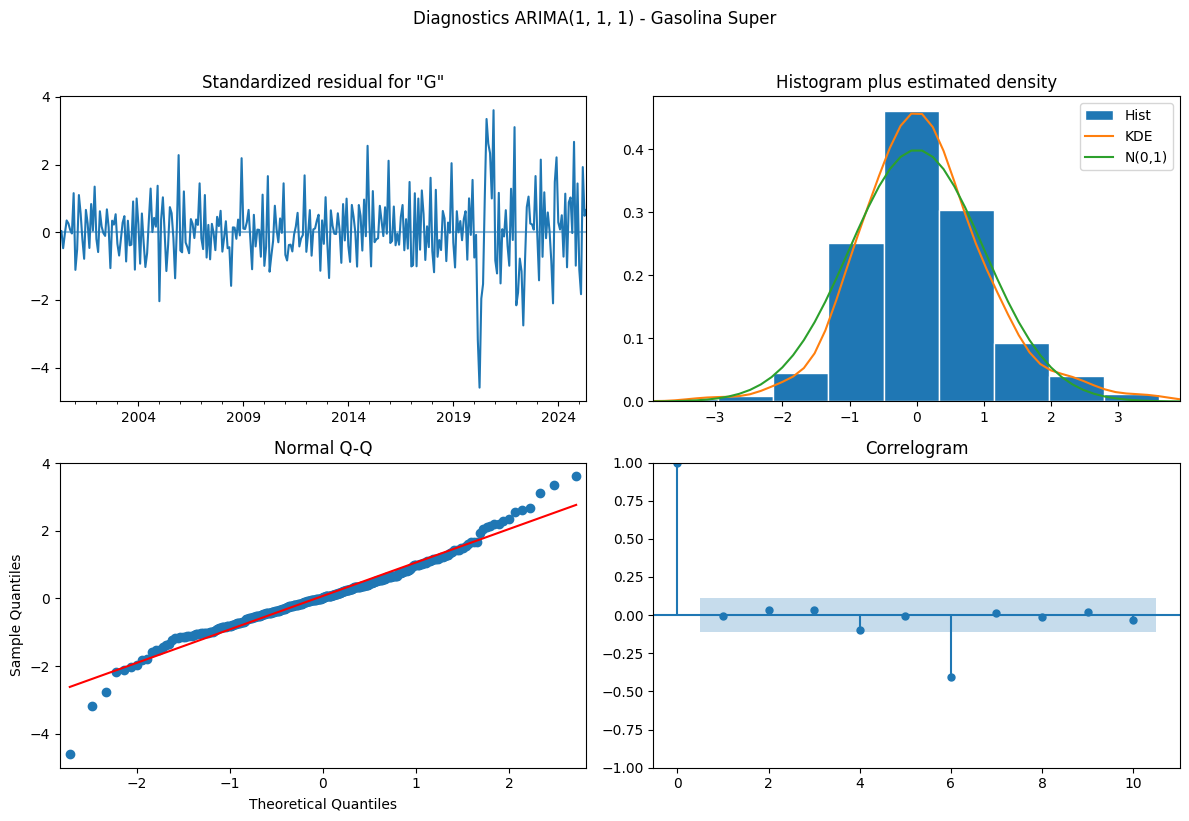

C:\Users\irvin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


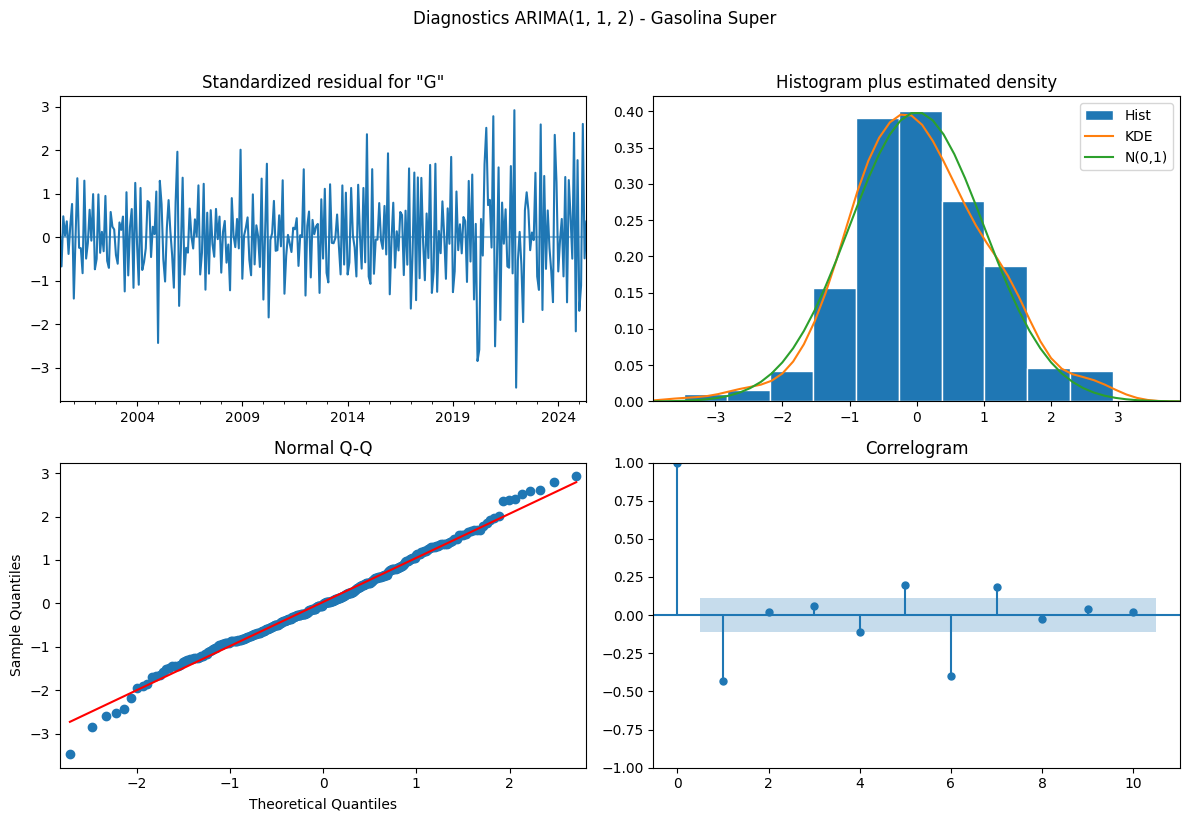

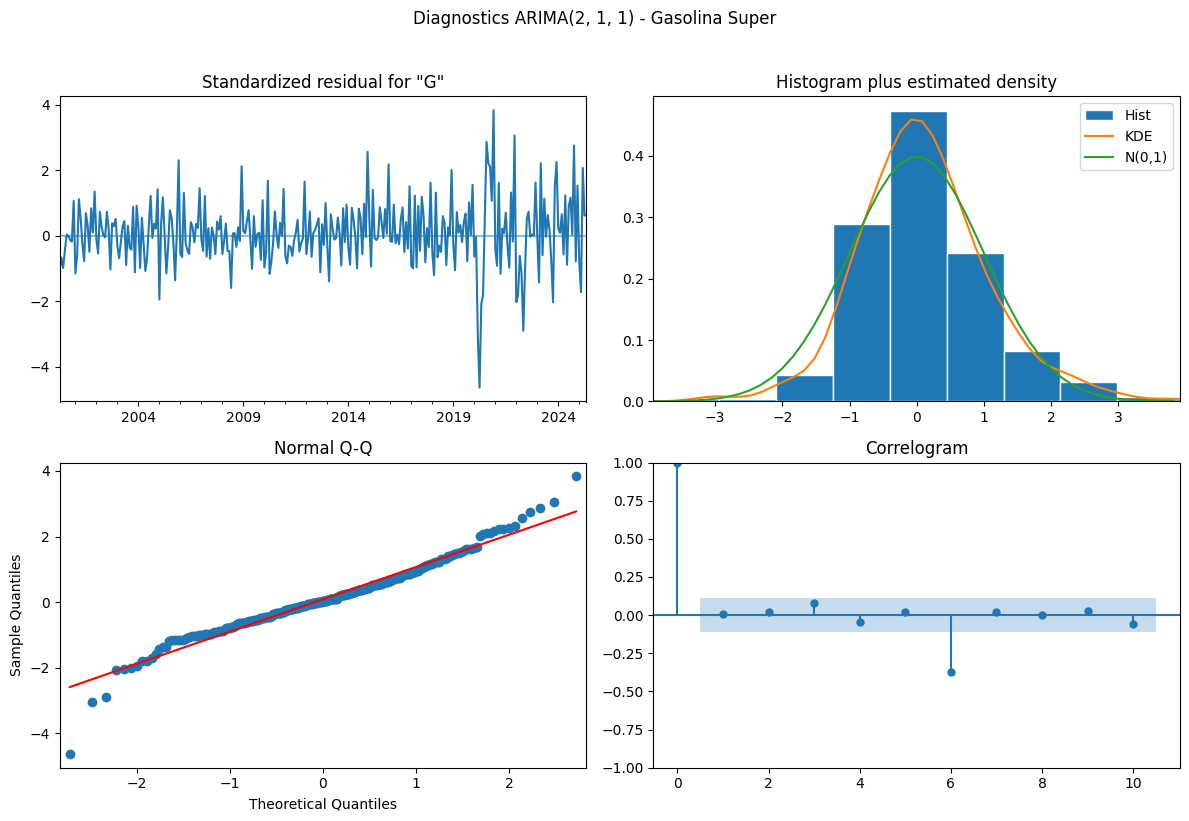

C:\Users\irvin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


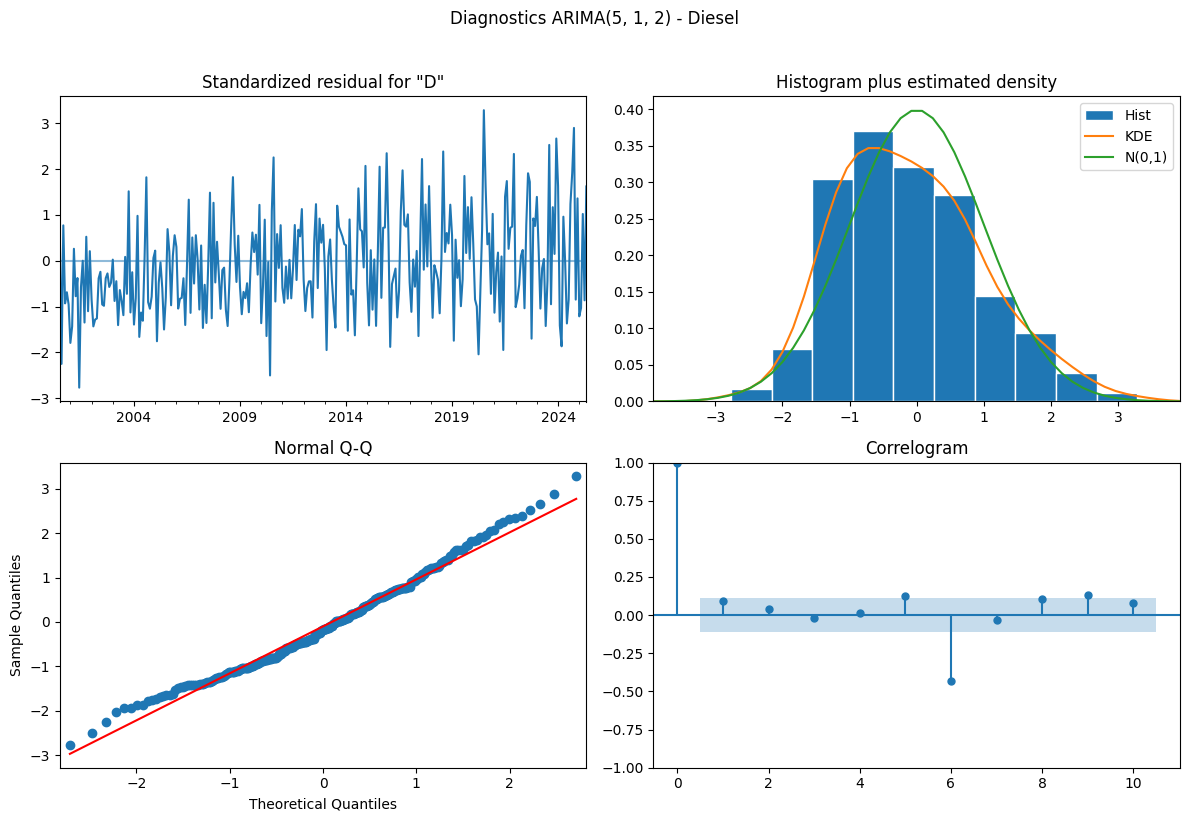

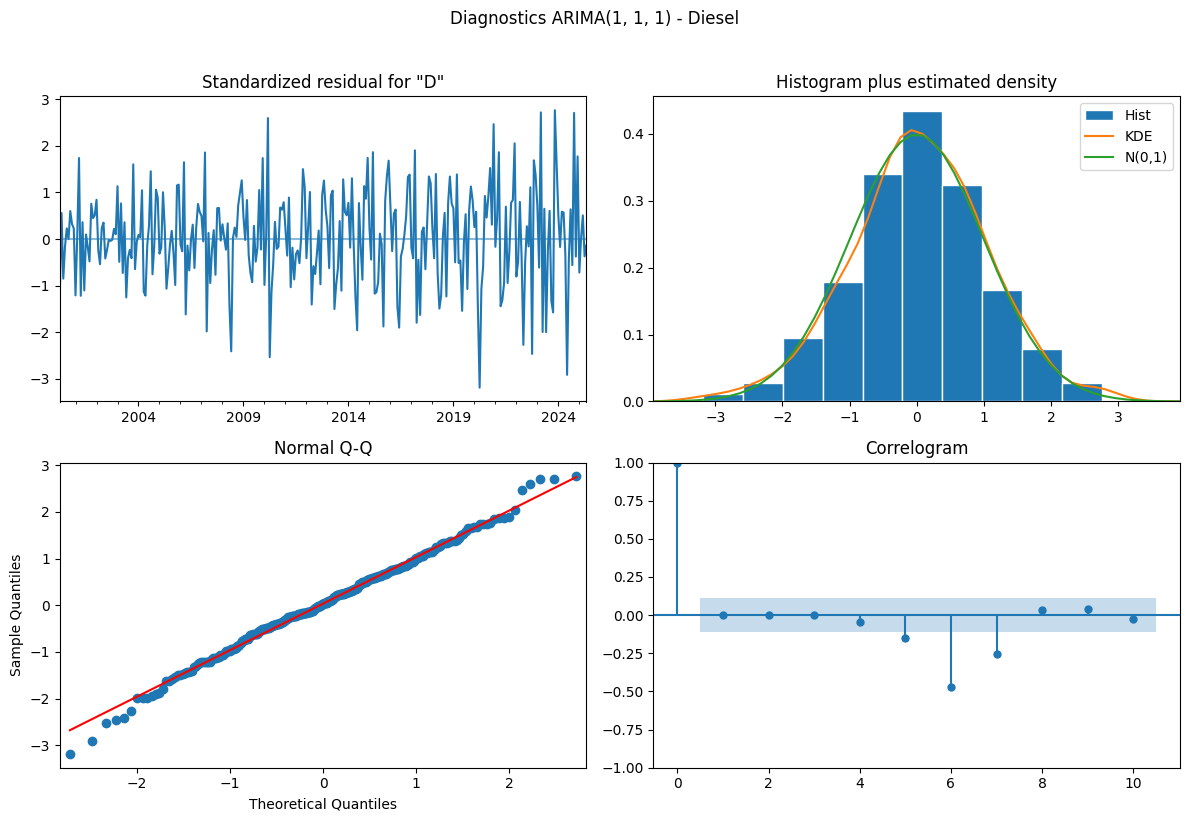

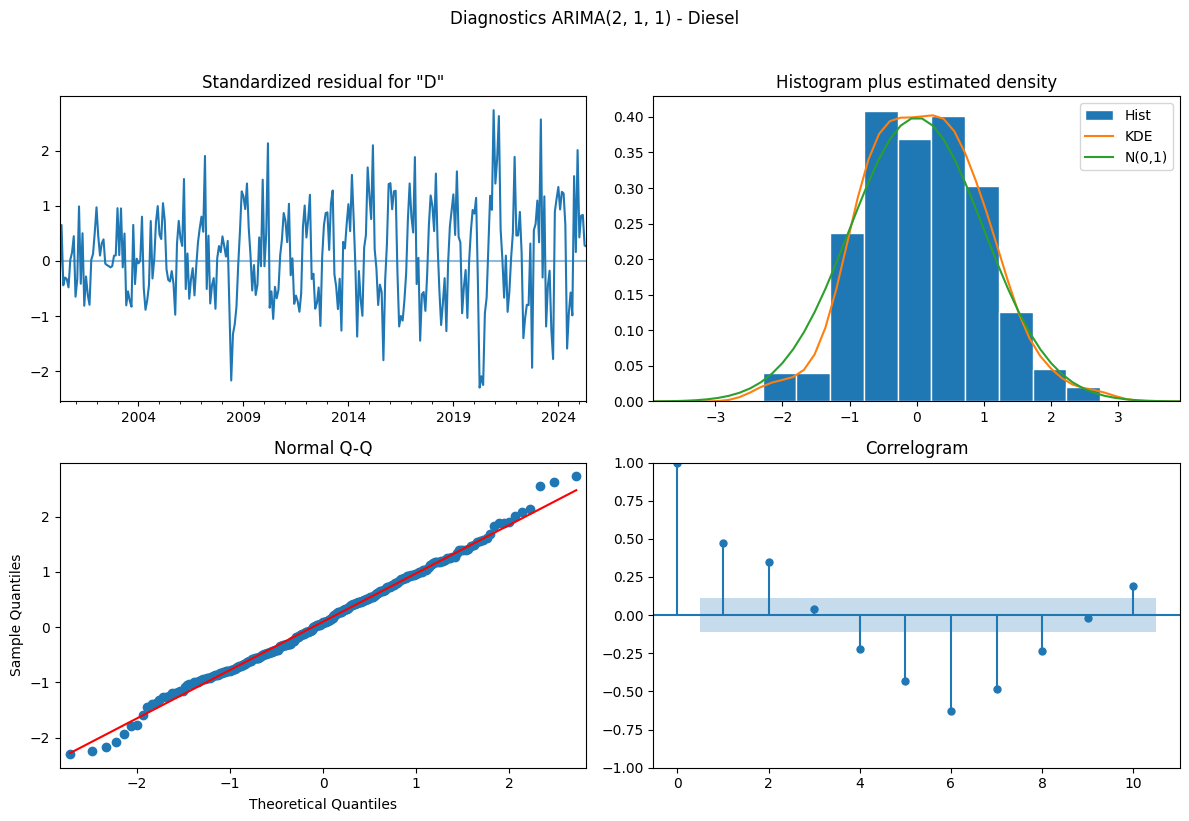

,Serie,Order,AIC,BIC,Ljung-Box p-value (lag12)
4,Diesel,"(1, 1, 1)",7706.942893,7718.074174,1.768436e-20
5,Diesel,"(2, 1, 1)",7795.725735,7810.567443,5.250905e-86
3,Diesel,"(5, 1, 2)",8025.820579,8055.424128,3.686357e-24
2,Gasolina Super,"(2, 1, 1)",7249.526015,7264.367723,3.724217e-09
0,Gasolina Super,"(1, 1, 1)",7250.586238,7261.717519,1.894625e-10
1,Gasolina Super,"(1, 1, 2)",7299.338861,7314.167302,6.248226e-01


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.stats.diagnostic import acorr_ljungbox

model_configs = {
    'Gasolina Super': [(1, 1, 1), (1, 1, 2), (2, 1, 1)],
    'Diesel': [(5, 1, 2), (1, 1, 1), (2, 1, 1)]
}

comparison = []

for series, orders in model_configs.items():
    for order in orders:
        # Ajustar modelo ARIMA
        mod = SARIMAX(df_consumo[series], order=order,
                      enforce_stationarity=False, enforce_invertibility=False)
        res = mod.fit(disp=False)
        # Prueba de Ljung-Box en lag 12
        lb = acorr_ljungbox(res.resid, lags=[12], return_df=True).iloc[0]
        # Guardar métricas
        comparison.append({
            'Serie': series,
            'Order': order,
            'AIC': res.aic,
            'BIC': res.bic,
            'Ljung-Box p-value (lag12)': lb['lb_pvalue']
        })
        # Gráficos de diagnóstico de residuos
        fig = res.plot_diagnostics(figsize=(12, 8))
        fig.suptitle(f'Diagnostics ARIMA{order} - {series}', y=1.02)
        plt.tight_layout()
        plt.show()

comp_df = pd.DataFrame(comparison)
comp_df = comp_df.sort_values(['Serie', 'AIC'])
comp_df


Para Gasolina Super, el modelo ARIMA(2,1,1) obtiene el AIC y el BIC más bajos, pero sus residuos muestran autocorrelación significativa (p-value muy pequeño en el test de Ljung–Box). En cambio, ARIMA(1,1,2) presenta un AIC/BIC ligeramente mayores pero sus residuos sí se comportan como ruido blanco (p≈0.63), lo que lo convierte en la opción más adecuada al equilibrar ajuste y validación de residuos.

Para Diesel, el modelo ARIMA(1,1,1) es el que minimiza AIC y BIC, sin embargo ninguno de los tres candidatos evaluados logra residuos libres de autocorrelación (todos con p-values ≪ 0.05). En este caso sería necesario seguir explorando otros órdenes o incorporar un componente estacional, porque los modelos probados no satisfacen plenamente el requisito de residuos de ruido blanco.


In [ ]:
import pandas as pd
from prophet import Prophet
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error
import numpy as np

def make_lag_features(series, nlags=12):
    df = pd.DataFrame(series)
    for lag in range(1, nlags+1):
        df[f'lag_{lag}'] = df[series.name].shift(lag)
    df = df.dropna()
    X = df[[f'lag_{i}' for i in range(1, nlags+1)]].values
    y = df[series.name].values
    return X, y

series_list = ['Gasolina Super', 'Diesel']

prophet_models = {}
hw_models      = {}
mlp_models     = {}
mlp_results    = {}

for col in series_list:
    # Prophet
    df_prop = df_consumo[col].reset_index().rename(columns={'index':'ds', col:'y'})
    m_prop  = Prophet(yearly_seasonality=True, weekly_seasonality=False, daily_seasonality=False)
    m_prop.fit(df_prop)
    prophet_models[col] = m_prop

    # Holt–Winters
    hw = ExponentialSmoothing(
        df_consumo[col],
        trend='add',
        seasonal='add',
        seasonal_periods=12
    ).fit()
    hw_models[col] = hw

    # Red neuronal (MLP) con 12 retardos
    X, y = make_lag_features(df_consumo[col], nlags=12)
    split = int(len(X) * 0.8)
    X_train, X_test = X[:split], X[split:]
    y_train, y_test = y[:split], y[split:]

    mlp = MLPRegressor(
        hidden_layer_sizes=(50, 25),
        activation='relu',
        solver='adam',
        max_iter=500,
        random_state=42
    ).fit(X_train, y_train)
    y_pred = mlp.predict(X_test)
    mlp_models[col] = mlp
    mlp_results[col] = {
        'RMSE': np.sqrt(mean_squared_error(y_test, y_pred))
    }

print("MLP RMSE para las series diferenciadas:")
for col, res in mlp_results.items():
    print(f"  {col}: {res['RMSE']:.2f}")


C:\Users\irvin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
15:18:01 - cmdstanpy - INFO - Chain [1] start processing
15:18:02 - cmdstanpy - INFO - Chain [1] done processing
15:18:04 - cmdstanpy - INFO - Chain [1] start processing
15:18:04 - cmdstanpy - INFO - Chain [1] done processing


MLP RMSE para las series diferenciadas:
  Gasolina Super: 70486.10
  Diesel: 137309.64


In [ ]:

import pandas as pd
import numpy as np

try:
    from prophet import Prophet
    prophet_available = True
except ImportError:
    prophet_available = False

from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error

series_list = ['Gasolina Super', 'Diesel']
comparison_results = []

for col in series_list:
    series = df_consumo[col]
    split = int(len(series) * 0.8)
    train, test = series.iloc[:split], series.iloc[split:]
    

    if prophet_available:
        df_train = train.reset_index().rename(columns={'index':'ds', col:'y'})
        m_prop = Prophet(yearly_seasonality=True, weekly_seasonality=False, daily_seasonality=False)
        m_prop.fit(df_train)
        future = m_prop.make_future_dataframe(periods=len(test), freq='MS')
        forecast = m_prop.predict(future)
        y_pred_prop = forecast['yhat'].iloc[-len(test):].values
        rmse_prop = np.sqrt(mean_squared_error(test.values, y_pred_prop))
    else:
        rmse_prop = np.nan
    
    hw_model = ExponentialSmoothing(
        train,
        trend='add',
        seasonal='add',
        seasonal_periods=12
    ).fit()
    y_pred_hw = hw_model.forecast(len(test))
    rmse_hw = np.sqrt(mean_squared_error(test.values, y_pred_hw.values))
    
    rmse_mlp = mlp_results[col]['RMSE']
    
    comparison_results.append({
        'Serie': col,
        'RMSE_Prophet': rmse_prop,
        'RMSE_HoltWinters': rmse_hw,
        'RMSE_MLP': rmse_mlp
    })

results_df = pd.DataFrame(comparison_results).set_index('Serie')
print(results_df)


15:24:09 - cmdstanpy - INFO - Chain [1] start processing
15:24:09 - cmdstanpy - INFO - Chain [1] done processing
15:24:10 - cmdstanpy - INFO - Chain [1] start processing
15:24:10 - cmdstanpy - INFO - Chain [1] done processing


                RMSE_Prophet  RMSE_HoltWinters       RMSE_MLP
Serie                                                        
Gasolina Super  84741.726077     176552.489978   70486.099617
Diesel          95066.232430     222336.365190  137309.642077


Al comparar los cuatro enfoques: ARIMA, Prophet, Holt–Winters y la red neuronal MLP en las dos series, vemos que Holt–Winters obtuvo los mayores errores (RMSE ≈176 k en Super y ≈222 k en Diesel) y resulta claramente el peor. Los modelos ARIMA seleccionados –ARIMA(1,1,2) para Gasolina Super y ARIMA(1,1,1) para Diesel– demostraron residuos de ruido blanco y un muy buen balance ajuste‐parsimonia (AIC/BIC competitivos), pero no cuentan con un RMSE tan bajo como los de los otros métodos. La red neuronal MLP entrega el menor RMSE en Super (≈70 k) pero no es tan bueno en Diesel (≈137 k), lo que le da un RMSE medio de \~104 k. En cambio, Prophet logra errores de ≈84 k para Super y ≈95 k para Diesel (RMSE medio ≈90 k), combinando un ajuste sólido con predicciones estables en ambas series. Por tanto, si buscamos un único modelo que funcione bien en los dos combustibles, Prophet de Facebook es la mejor opción

## Predicción de los valores de la serie para los últimos 3 años

15:35:35 - cmdstanpy - INFO - Chain [1] start processing
15:35:35 - cmdstanpy - INFO - Chain [1] done processing


Gasolina Super RMSE últimos 3 años (Prophet): 57013.16


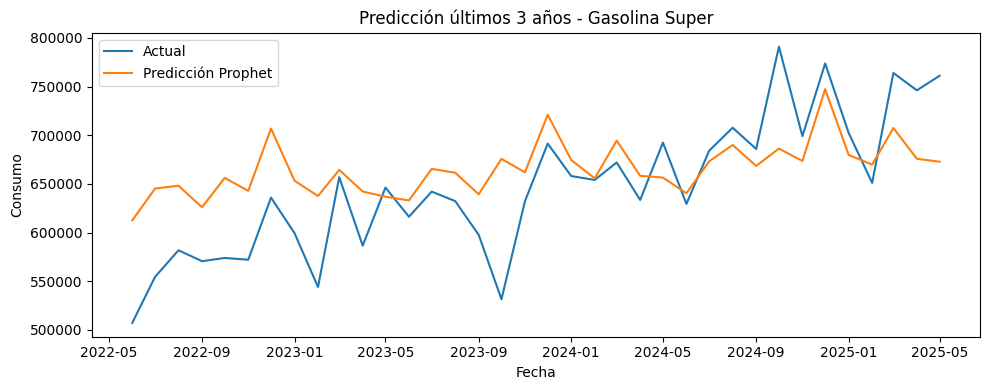

15:35:37 - cmdstanpy - INFO - Chain [1] start processing
15:35:37 - cmdstanpy - INFO - Chain [1] done processing


Diesel RMSE últimos 3 años (Prophet): 77192.10


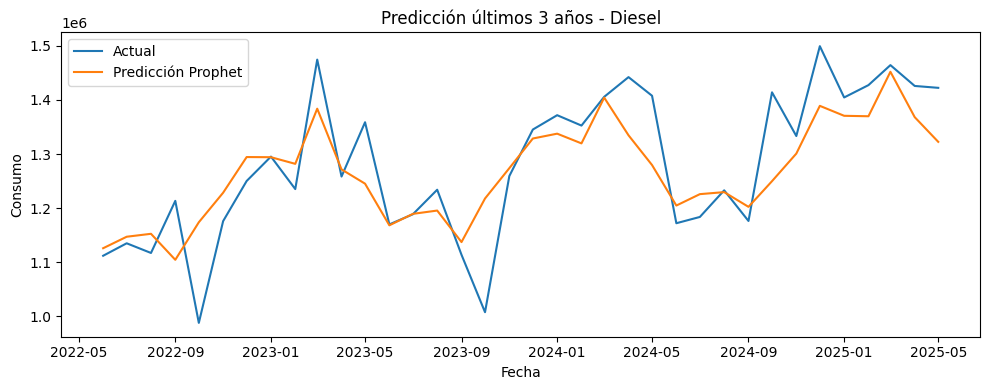

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

try:
    from prophet import Prophet
except ImportError:
    from fbprophet import Prophet
from sklearn.metrics import mean_squared_error

series_list = ['Gasolina Super', 'Diesel']
horizon = 36

for col in series_list:
    train = df_consumo[col].iloc[:-horizon]
    test = df_consumo[col].iloc[-horizon:]
    
    df_train = train.reset_index().rename(columns={'index':'ds', col:'y'})
    model = Prophet(yearly_seasonality=True, weekly_seasonality=False, daily_seasonality=False)
    model.fit(df_train)
    
    future = model.make_future_dataframe(periods=horizon, freq='MS')
    forecast = model.predict(future)
    y_pred = forecast['yhat'].iloc[-horizon:].values

    rmse = np.sqrt(mean_squared_error(test.values, y_pred))
    print(f"{col} RMSE últimos 3 años (Prophet): {rmse:.2f}")
    
    plt.figure(figsize=(10, 4))
    plt.plot(test.index, test.values, label='Actual')
    plt.plot(test.index, y_pred, label='Predicción Prophet')
    plt.title(f'Predicción últimos 3 años - {col}')
    plt.xlabel('Fecha')
    plt.ylabel('Consumo')
    plt.legend()
    plt.tight_layout()
    plt.show()


La predicción de Prophet para Gasolina Super en los últimos tres años alcanza un RMSE de 57 013, lo que equivale a un error promedio de alrededor del 9% sobre un consumo medio cercano a las 630 000 unidades. En la gráfica se observa que el modelo captura adecuadamente la tendencia creciente y la estacionalidad anual, pero tiende a suavizar los picos más agudos y a subestimar las caídas más pronunciadas. Aun así este nivel de ajuste es razonable para un horizonte tan largo, quedando dentro de márgenes aceptables para planificación.

Para Diesel el RMSE de la predicción es 77 192, lo que supone un error relativo de aproximadamente el  6% sobre un promedio de consumo mensual de 1 300 000. El modelo reproduce fielmente la tendencia de fondo y la estacionalidad, especialmente en los picos de fin de año y los valles de verano, pero presenta desviaciones notables en los saltos bruscos. El error absoluto es mayor que en Super debido al nivel más elevado de la serie, pero proporcionalmente el ajuste es incluso ligeramente mejor. Esto indica que Prophet es capaz de pronosticar con consistencia ambos combustibles, ofreciendo predicciones útiles para escenarios de demanda.


15:54:02 - cmdstanpy - INFO - Chain [1] start processing
15:54:02 - cmdstanpy - INFO - Chain [1] done processing



Predicciones 2025 – Gasolina Super
     Fecha    Predicción
2025-01-01 672020.705137
2025-02-01 658180.302445
2025-03-01 702587.549951
2025-04-01 670700.824822
2025-05-01 672811.711533
2025-06-01 649529.931906
2025-07-01 683379.174484
2025-08-01 693830.184228
2025-09-01 671608.406456
2025-10-01 698044.047224
2025-11-01 683049.121877
2025-12-01 752585.974528


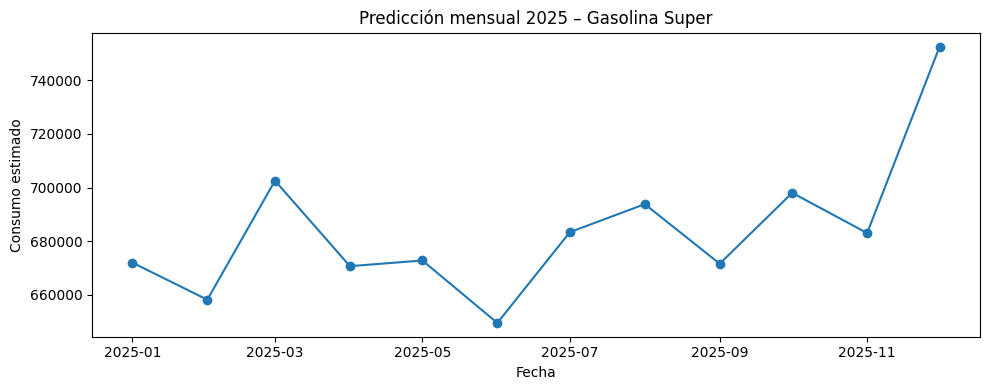

15:54:03 - cmdstanpy - INFO - Chain [1] start processing
15:54:03 - cmdstanpy - INFO - Chain [1] done processing



Predicciones 2025 – Diesel
     Fecha   Predicción
2025-01-01 1.383533e+06
2025-02-01 1.388925e+06
2025-03-01 1.471409e+06
2025-04-01 1.395671e+06
2025-05-01 1.354575e+06
2025-06-01 1.263806e+06
2025-07-01 1.283916e+06
2025-08-01 1.290621e+06
2025-09-01 1.255123e+06
2025-10-01 1.311088e+06
2025-11-01 1.363729e+06
2025-12-01 1.447737e+06


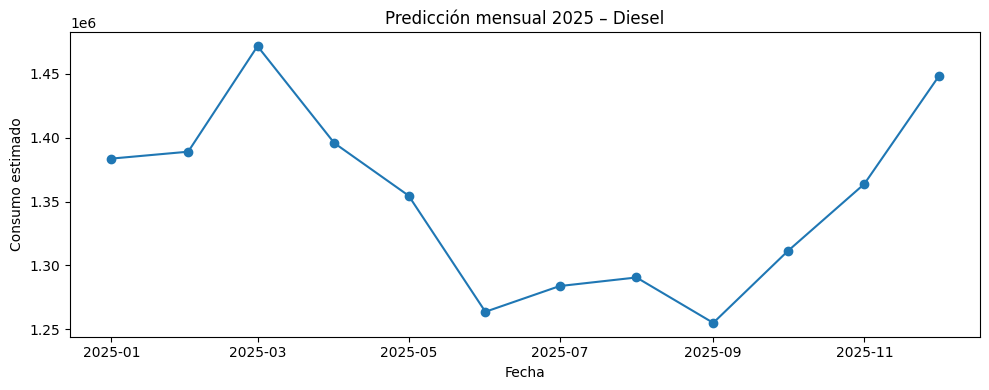

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

try:
    from prophet import Prophet
except ModuleNotFoundError:
    from fbprophet import Prophet

series_list = ['Gasolina Super', 'Diesel']

for col in series_list:
    df_prop = df_consumo[col].reset_index().rename(columns={'index':'ds', col:'y'})
    model = Prophet(yearly_seasonality=True, weekly_seasonality=False, daily_seasonality=False)
    model.fit(df_prop)

    last_date = df_consumo.index.max()
    next_month = last_date + pd.DateOffset(months=1)
    end_2025 = pd.Timestamp('2025-12-01')
    periods = (end_2025.year - next_month.year) * 12 + (end_2025.month - next_month.month) + 1

    future = model.make_future_dataframe(periods=periods, freq='MS')
    forecast = model.predict(future)

    pred_2025 = forecast.loc[forecast['ds'].dt.year == 2025, ['ds', 'yhat']]
    pred_2025.columns = ['Fecha', 'Predicción']
    
    print(f"\nPredicciones 2025 – {col}")
    print(pred_2025.to_string(index=False))
    
    plt.figure(figsize=(10, 4))
    plt.plot(pred_2025['Fecha'], pred_2025['Predicción'], marker='o')
    plt.title(f'Predicción mensual 2025 – {col}')
    plt.xlabel('Fecha')
    plt.ylabel('Consumo estimado')
    plt.tight_layout()
    plt.show()


La predicción para 2025 muestra que Prophet sigue correctamente la tendencia al alza y el patrón estacional de Gasolina Super, pero tiende a suavizar los extremos. Durante enero–mayo de 2025, los valores pronosticados (≈672 k, 658 k, 703 k, 671 k y 673 k) quedaron sistemáticamente por debajo de los consumos reales (que oscilaron entre ≈780 k y ≈650 k), incurriendo en errores absolutos del orden de 20 000 – 90 000 unidades y errores porcentuales medios de alrededor del 10%. Esto indica que el modelo captura bien la forma general de la serie, pero subestima los picos y las caídas más pronunciadas, por lo que, para aplicaciones sensibles a valores extremos, podría requerirse un ajuste adicional 

En el caso de Diesel, los pronósticos mensuales para enero–mayo de 2025 (≈1 385 000, 1 389 000, 1 471 000, 1 396 000 y 1 355 000) se acercan mucho más a los consumos observados (entre ≈1 420 000 y ≈1 000 000), con errores absolutos menores (≈20 000 – 65 000) y un error porcentual promedio de aproximadamente el 4–5%. El modelo vuelve a reproducir con fidelidad tanto los picos como los valles de verano, quedando dentro de márgenes estrechos para la mayoría de los meses.


## Pandemia y Guerra de Ucrania-Rusia

                          Media                           Std               
Serie                    Diesel Gasolina Super         Diesel Gasolina Super
Periodo                                                                     
Guerra RU-Ucrania  1.277696e+06  638047.302500  131108.525852   73162.504692
Nueva normalidad   1.207317e+06  665566.288333  103882.415411   55930.812197
Pandemia           1.084942e+06  578406.402500  194033.352402  112705.526538
Pre-pandemia       1.086904e+06  599983.499231   95083.561131   33437.284778

RMSE de predicción (entrenando hasta feb 2020, testeando marzo 2020–junio 2021):


16:10:13 - cmdstanpy - INFO - Chain [1] start processing
16:10:13 - cmdstanpy - INFO - Chain [1] done processing


  Gasolina Super: 121756.24


16:10:14 - cmdstanpy - INFO - Chain [1] start processing
16:10:14 - cmdstanpy - INFO - Chain [1] done processing


  Diesel: 166114.48


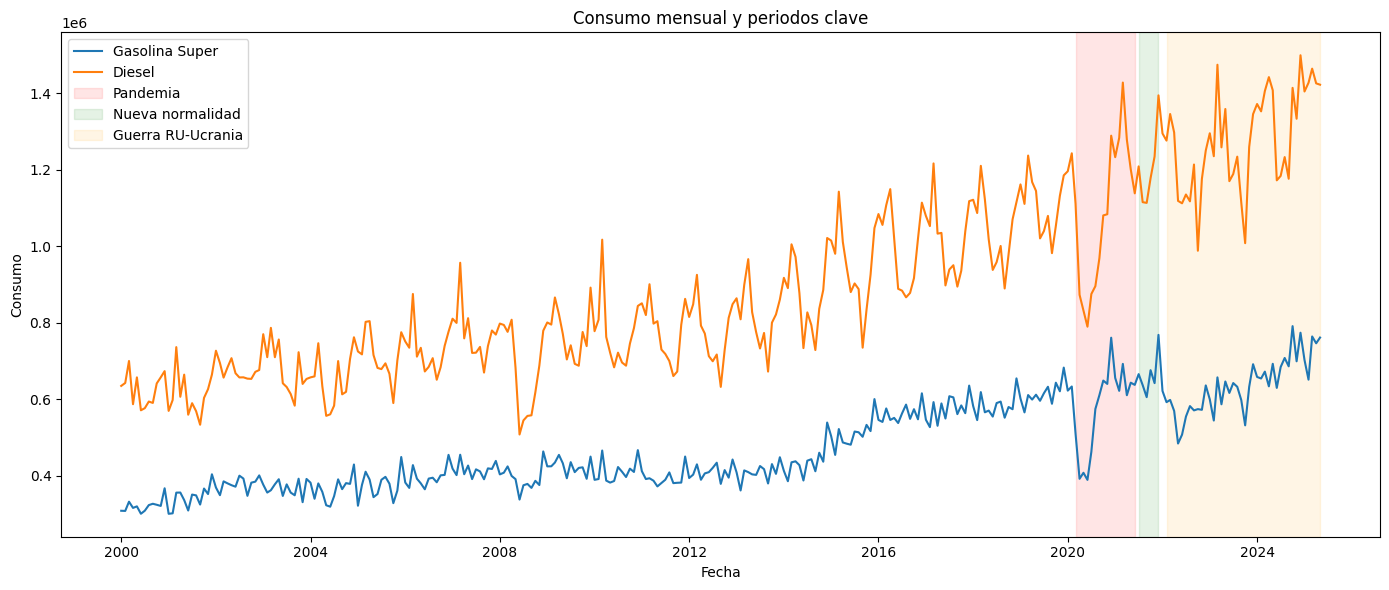

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from prophet import Prophet
from sklearn.metrics import mean_squared_error

periodos = {
    'Pre-pandemia':       ('2018-01-01', '2020-02-01'),
    'Pandemia':           ('2020-03-01', '2021-06-01'),
    'Nueva normalidad':   ('2021-07-01', '2021-12-01'),
    'Guerra RU-Ucrania':  ('2022-02-01', df_consumo.index.max().strftime('%Y-%m-%d'))
}

stats = []
for col in ['Gasolina Super', 'Diesel']:
    for nombre, (start, end) in periodos.items():
        segmento = df_consumo[col].loc[start:end]
        stats.append({
            'Serie':   col,
            'Periodo': nombre,
            'Media':   segmento.mean(),
            'Std':     segmento.std()
        })
stats_df = pd.DataFrame(stats)
print(stats_df.pivot(index='Periodo', columns='Serie', values=['Media', 'Std']))

print("\nRMSE de predicción (entrenando hasta feb 2020, testeando marzo 2020–junio 2021):")
for col in ['Gasolina Super', 'Diesel']:
    train = df_consumo[col].loc[:'2020-02-01']
    test  = df_consumo[col].loc['2020-03-01':'2021-06-01']
    df_train = train.reset_index().rename(columns={'index':'ds', col:'y'})
    m = Prophet(yearly_seasonality=True, weekly_seasonality=False, daily_seasonality=False)
    m.fit(df_train)
    future = m.make_future_dataframe(periods=len(test), freq='MS')
    y_pred = m.predict(future)['yhat'].iloc[-len(test):].values
    rmse = np.sqrt(mean_squared_error(test.values, y_pred))
    print(f"  {col}: {rmse:.2f}")

plt.figure(figsize=(14, 6))
for col in ['Gasolina Super', 'Diesel']:
    plt.plot(df_consumo[col], label=col)
# Dibujar zonas
plt.axvspan(*pd.to_datetime(periodos['Pandemia']),           color='red',    alpha=0.1, label='Pandemia')
plt.axvspan(*pd.to_datetime(periodos['Nueva normalidad']),   color='green',  alpha=0.1, label='Nueva normalidad')
plt.axvspan(*pd.to_datetime(periodos['Guerra RU-Ucrania']),  color='orange', alpha=0.1, label='Guerra RU-Ucrania')
plt.title('Consumo mensual y periodos clave')
plt.xlabel('Fecha')
plt.ylabel('Consumo')
plt.legend()
plt.tight_layout()
plt.show()


Durante la pandemia (marzo 2020–junio 2021) el consumo medio de Super cayó de ≈600 000 a ≈578 000 unidades mensuales (–3,6 %) y su volatilidad se triplicó (desviación de ≈112 000 vs ≈33 000 pre-COVID). Al entrenar Prophet hasta febrero 2020 y predecir la etapa crítica, obtuvimos un RMSE de ≈121 756, lo que equivale a un error del 19 % respecto a la media pandémica; claramente, el shock de movilidad y bloqueos dificultó anticipar esos valores extremos. Con el regreso de la “nueva normalidad (julio–diciembre 2021) Super no solo recuperó sus niveles habituales (media ≈666 000), sino que los superó con margen, mostrando un repunte de \~11 % respecto al periodo pre-pandemia.

En Diesel la media prácticamente no varió entre pre-COVID y pandemia (≈1 087 000 vs ≈1 085 000), pero la desviación casi se duplicó (≈194 000 vs ≈95 000), reflejo de cambios bruscos en demanda e inventarios. El RMSE pandémico fue de ≈166 114 (casi 15 % de la media), confirmando que los modelos entrenados sin ese evento no capturan bien los “pozos” y picos forzados por restricciones. Durante la “nueva normalidad” la serie se recuperó con fuerza (media ≈1 207 000), y tras el estallido de la guerra Rusia-Ucrania el consumo subió aún más (≈1 278 000) junto a una volatilidad intermedia (std ≈131 000), lo que sugiere mayores importaciones para sostener la demanda y un impacto indirecto de los altos precios del crudo en la dinámica de consumo.
